In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import winshell # create windows shortcut
import json

import requests
import time
from bs4 import BeautifulSoup as bs
import shutil
import PIL
from PIL import Image
from io import BytesIO
import urllib.request
import time

## new features
- class Work
- class Window
- api: list of item
- scrape main page
- scarep torrent list


In [4]:
#current working dir
cwd = os.getcwd()
print('Current working directory is: ' + os.getcwd())
#set cwd to D:\\sadpanda
newcwd = r'D:\sadpanda'
os.chdir(newcwd)
print('Current working directory is: ' + os.getcwd())

Current working directory is: D:\sadpanda


## API:
- 25 entries per request
- 4-5 sequential requests before waiting ~ 5sec
https://ehwiki.org/wiki/API

- try popular artist with lots of translations:
    - -> katsura yoshiaki

In [2]:
a1 = 'https://e-hentai.org/tag/artist:katsurai+yoshiaki'

In [3]:
panda_api = 'https://api.e-hentai.org/api.php'
database_path = 'D:\\sadpanda\\database'

In [4]:
url1 = 'https://e-hentai.org/g/1824475/58cc4ae24a/' 
#[Memeya (Meme50)] Okane Daisuki
url2 = 'https://e-hentai.org/g/1823375/7e3cc453c1/'
#[Memeya (Meme50)] Okane Daisuki | I Love Money [Rewards Edition] (Ouch Translations) [English]

In [5]:
#NORMAL FUNCTIONS HERE

def create_url_shortcut(target_url, shortcut_name=None):
    """Needs to import winshell. 
    Create shortcut of target url on desktop with shortcut name provided.
    If no name is provided, filename will be the same as target_url.
    """
    assert type(target_url)==str, "target_url must be a string"
    if not shortcut_name:
        shortcut_name = target_url
    desktop = winshell.desktop()
    #create the file path
    path = os.path.join(desktop, shortcut_name)
    target = target_url
    with open(path, 'w') as shortcut:
        shortcut.write('[InternetShortcut]\n')
        shortcut.write('URL=%s' % target)

        
        
def build_request(entry_list):
    data = {
              "method": "gdata",
              "gidlist": entry_list,
              "namespace": 1
            } 
    return json.dumps(data)
  
def download_img(url):
    """Send a request to img url and return the response.
    If response is successful (code 200) then resp is returned, otherwise return None"""
    resp = requests.get(url)
    if resp.status_code == 200:
        return resp
    return None

def do_one(panda_url):
    """Create a Gallery, POST, process tags and save to disk"""
    g = Gallery(panda_url)
    g.POST()
    g.process_tags()
    info = g.get_info(print_=True)
    fol = g.save(print_=True)   

In [ ]:
'''               
request = {
  "method": "gdata",
  "gidlist": [
      [gid, token]
  ],
  "namespace": 1
}
'''

In [6]:
class Gallery():
    def __init__(self, url):
        self.url = url
        self.gid = None
        self.token = None
        self.process_url() # fill self.gid and self.token
        self.POST_data = json.dumps({
              "method": "gdata",
              "gidlist": [
                  [self.gid, self.token]
              ],
              "namespace": 1
            })
        self.resp = None
        self.data = None #python dict form
        self.basic_tags = ['title', 'title_jpn', 'category', 'filecount']
        
        #tag groups below
        self.basic_info = None
        self.all_tags = None
        self.content_tags = None
        self.female_tags = None
        self.male_tags = None
        self.misc_tags = None
        
        #useful_tags
        self.thumb = None
        self.group = None
        self.artist = None
        
        #process tags
        #self.process_tags()
        
        
    def process_url(self,verbose=False):
        """Extract GID and Token from url then set respective instance attributes"""
        parts = self.url.split('/')
        for i in range(len(parts)):
            if parts[i] != 'g':
                continue
            else:
                index_of_g = i
                self.gid = int(parts[index_of_g + 1])
                self.token = str(parts[index_of_g + 2])
                if verbose:
                    print("GID:" + self.gid,', Token:' + self.token)
                break
                
    def get_gid(self):
        return self.gid
    def get_token(self):
        return self.token
    
    #changes: POST data processing now shifts to API class
    def get_both(self):
        return [self.gid, self.token]                
    def get_POST_data(self):
        return json.dumps(self.POST_data)
    #def get_POST_data(self):
        
    
    
    def POST(self, print_=True):
        """Send POST request to ehentai API. 
        Store its response and content if request is successful"""
        r = requests.post(panda_api, data=self.POST_data)
        if r.status_code == 200:
            print("---Code 200 - POST request susscessful!---")
            self.resp = r
            self.data = json.loads(r.content)
            
    def get_data(self):
        return self.data
    

    def process_tags(self):
        """process tags"""
        assert type(self.data) == dict, """data must be a Python dictionary type"""
        self.all_tags = self.data['gmetadata'][0]
        self.content_tags = self.all_tags['tags']
        assert type(self.all_tags)==dict, 'File error: not a Python dictionary'
        assert self.content_tags != None, "content_tags must no be empty"
        
        self.thumb = self.all_tags.get('thumb', None)
        self.find_group()
        self.find_artist()
        self.categorize_tags()
        self.set_info()
        

    def categorize_tags(self): 
        """Categorize content tags into 3 groups: female, male and misc."""
        assert self.content_tags != None, "content_tags must no be empty"
        female_tags, male_tags, misc_tags = [], [], []
        for tag in self.content_tags:
            if 'female' in tag:
                female_tags.append(tag[len('female:'):])
            elif 'male' in tag:
                male_tags.append(tag[len('male:'):])
            else:
                misc_tags.append(tag)
        self.female_tags = female_tags
        self.male_tags = male_tags
        self.misc_tags = misc_tags

    def find_group(self):
        """Find group/circle(s) of work"""
        assert self.content_tags != None, "content_tags must no be empty"
        for tag in self.content_tags:
            if 'group:' in tag:
                self.group = tag[len('group:'):]
                
    def find_artist(self):
        """Find artist(s) of work."""
        assert self.content_tags != None, "content_tags must no be empty"
        for tag in self.content_tags:
            if 'artist:' in tag:
                self.artist = tag[len('artist:'):]
            #don't put an ELSE CLAUSE HERE STUPIDDDDDD

    def set_info(self):        
        """Print basic information about the book"""
        self.basic_info = {key.capitalize():self.all_tags[key] for key in self.basic_tags if self.all_tags.get(key)}
        if self.group:
            self.basic_info['Group'] = self.group
        if self.artist:
            self.basic_info['Artist'] = self.artist
            
    def get_info(self, print_=True):
        """Return basic info and optionally print it"""
        if print_:
            for key in self.basic_info:
                print(key + ': ' + self.basic_info[key])
        return self.basic_info

    def save(self, print_=True):
        """create a folder in the database with url, data API and cover image.
        Return the full directory path"""
        #get gid and url
        gid = str(self.gid)
        url = self.url
        cover_url = self.thumb
        
        #create folder whose name is the GID
        folder_path = os.path.join(database_path, gid)
        os.makedirs(folder_path, exist_ok=True)

        #write json data
        data_filename = gid + '_data.json'
        filepath = os.path.join(folder_path, data_filename)
        with open(filepath, 'w') as outfile:
            json.dump(self.data, outfile)

        #write cover image
        if cover_url: # if cover_url found
             #get file type
            img_name = cover_url.split('/')[-1]
            ext = img_name[img_name.find('.')+1 :]
            #name file and write file to disk
            filename = gid + '_cover.' + ext
            filepath = os.path.join(folder_path, filename)
            r = download_img(cover_url)
            if r: # if request successful i.e not None then write image to disk
                with open(filepath, 'wb') as f:
                    f.write(r.content)

        #create a url shortcut
        filename = gid + '_link.url' 
        create_url_shortcut(url, filename)    
        #move url shortcut from desktop to save folder
        src = os.path.join(r'C:\Users\hviet\Desktop', filename)
        dest = os.path.join(folder_path,filename)
        shutil.move(src,dest)
        if print_:
            print('Link to folder', folder_path)
        return folder_path

In [17]:
class API:
    def __init__(self, API_url):
        self.API_url = API_url
    
    def POST(self):
        pass
    
    def GET(self):
        pass
    
class PandaAPI(API):
    def __init__(self, API_url):
        API.__init__(self, API_url)
    def POST(self, Gallery_list):
        assert type(Gallery_list)==list; 'must be a list of not more than 25 Gallery objects'
        data_list = []
        for gallery in Gallery_list:
            #gallery_POST_data = gallery.get_POST_data() # alist
            gallery_POST_data = gallery.get_both() # alist
            data_list.append(gallery_POST_data) 
        if len(data_list) > 25:
            data_list = data_list[:25] # take the first 25 items
        POST_data = json.dumps({
              "method": "gdata",
              "gidlist": data_list,
              "namespace": 1
            })
        r = requests.post(self.API_url, data=POST_data)
        if r.status_code == 200:
            print("---Code 200 - POST request susscessful!---")
            #self.resp = r
            #self.data = json.loads(r.content)
        return r
    def load_limit(self):
        """ if current time to time of 4th-previous call is less than 10 secs then 
        wait until at least 10 secs have elapsed"""
        #if the last call was successful and 6 secs have elapsed -> ok
        
        # else if last call was successful but 4 calls were made in the last 6 secs -> wait until 6 secs after the last call
        
        #if banned -> read and print the content of ban
        current_time = time.time()
        time_elapsed = current_time - self.fourth_previous_call
        if time_elapsed <= 10:
            time.sleep(10-)



In [18]:
Panda = PandaAPI('https://api.e-hentai.org/api.php')


r = requests.get(a1)
print(r) #200 means request went through
print(r.headers.get('content-type'))

soup = bs(r.text, 'html.parser')
type(soup) #bs4.BeautifulSoup

count = 0
gallery_urls = []
for item in soup.findAll('a'):
    link = item['href']
    #print(link)
    if 'e-hentai.org/g/' in link:
        print(link)
        gallery_urls.append(link)
        count += 1
print(count)

gallery_list = []
for url in gallery_urls:
    g = Gallery(url)
    gallery_list.append(g)

r = Panda.POST(gallery_list)

<Response [200]>
text/html; charset=UTF-8
0
---Code 200 - POST request susscessful!---


In [20]:
r.content

b'Your IP address has been temporarily banned for excessive pageloads which indicates that you are using automated mirroring/harvesting software. The ban expires in 58 minutes and 56 seconds'

In [27]:
import time
from math import ceil, floor
diff = 5.5001
print(ceil(diff))
round(diff)

6


6

In [10]:
Panda.API_url

'https://api.e-hentai.org/api.php'

In [73]:
g1 = Gallery(url1)
g1.POST()
data = g1.get_data()
g1.process_tags()
info = g1.get_info(print_=True)
fol = g1.save()

Code 200 - Susscessful request

Title: [Memeya (Meme50)] Okane Daisuki
Title_jpn: [メメ屋 (メメ50)] オカネダイスキ
Category: Doujinshi
Filecount: 40
Group: memeya
Artist: meme50
Link to folder D:\sadpanda\database\1824475


In [76]:
do_one(url2)

---Code 200 - POST request susscessful!---

Title: [Memeya (Meme50)] Okane Daisuki | I Love Money [Rewards Edition] (Ouch Translations) [English]
Title_jpn: [メメ屋 (メメ50)] オカネダイスキ [リワードエディション] [英訳]
Category: Doujinshi
Filecount: 37
Group: memeya
Artist: meme50
Link to folder D:\sadpanda\database\1823375


In [74]:
lst = []
u1 = 'https://e-hentai.org/g/1828482/56f35a1114/'
u2 = 'https://e-hentai.org/g/1828251/b92a98e353/'
u3 = 'https://e-hentai.org/g/1828225/53f0462bee/'
lst = [u1, u2, u3]
for item in lst:
    do_one(item)

Code 200 - Susscessful request

Title: [Crimson] Ki ga Tsuyoi Joshi Announcer ga Kutsujoku ni Taerarenaku Naru made Les Ijime Hen | A Strong-willed Announcer Was Disgraced Until She Couldn&#039;t Endure [English] [Kizlan]
Title_jpn: [クリムゾン] 気が強い女子アナウンサーが屈辱に耐えられなくなるまで レズ苛め編 [英訳]
Category: Doujinshi
Filecount: 47
Group: crimson
Artist: crimson
Link to folder D:\sadpanda\database\1828482
Code 200 - Susscessful request

Title: [AXZ (Kutani)] Hamegurui 3L - Sex shinai to Nukerare nai Seieki Dildo Daisakusen!! Hen (Kakegurui) [English] {Doujins.com}
Title_jpn: [AXZ (九手児)] ハ×グルイ3L セッ〇スしないと抜けられないセーエキディルド大決戦!!編 (賭ケグルイ) [英訳]
Category: Doujinshi
Filecount: 17
Group: axz
Artist: kutani
Link to folder D:\sadpanda\database\1828251
Code 200 - Susscessful request

Title: (C97) [Douganebuibui (Aburidashi Zakuro)] Oshioki Dar-sama (Girls und Panzer) [English] {Doujins.com}
Title_jpn: (C97) [ドウガネブイブイ (あぶりだしざくろ)] お仕置きダーさま (ガールズ&amp;パンツァー) [英訳]
Category: Doujinshi
Filecount: 14
Group: douganebuibui
Artist:

In [29]:
#{key.capitalize():g1.all_tags[key] for key in g1.basic_tags if g1.all_tags.get(key)}
data

{'gmetadata': [{'gid': 1824475,
   'token': '58cc4ae24a',
   'archiver_key': '447508--f604dcc88b62620621cf96f2a6d84dff972c5abd',
   'title': '[Memeya (Meme50)] Okane Daisuki',
   'title_jpn': '[メメ屋 (メメ50)] オカネダイスキ',
   'category': 'Doujinshi',
   'thumb': 'https://ehgt.org/dd/53/dd53833cc79cbd9d7c9bf1b1bb401284d84942ce-5822542-2508-3541-jpg_l.jpg',
   'uploader': 'nrdn25',
   'posted': '1610591009',
   'filecount': '40',
   'filesize': 143026823,
   'expunged': False,
   'rating': '4.72',
   'torrentcount': '2',
   'torrents': [{'hash': 'f812e520bb6cd598409689788222576e59928c19',
     'added': '1610454452',
     'name': '(同人誌) [メメ屋 (メメ50)] オカネダイスキ FANZA版 (オリジナル).zip',
     'tsize': '18612',
     'fsize': '29881676'},
    {'hash': '201c599aa72d65a3fcd2b085d49e40333738e5b8',
     'added': '1610517209',
     'name': '(同人誌) [メメ屋 (メメ50)] オカネダイスキ FANZA版 (オリジナル).zip',
     'tsize': '11354',
     'fsize': '287566099'}],
   'tags': ['parody:original',
    'group:memeya',
    'artist:meme50',
  

In [113]:
print(r.content)
type(r.content)

b'{"gmetadata":[{"gid":1823375,"token":"7e3cc453c1","archiver_key":"447488--1fcaf1ca35faeaa53806427221912443da9148f8","title":"[Memeya (Meme50)] Okane Daisuki | I Love Money [Rewards Edition] (Ouch Translations) [English]","title_jpn":"[\\u30e1\\u30e1\\u5c4b (\\u30e1\\u30e150)] \\u30aa\\u30ab\\u30cd\\u30c0\\u30a4\\u30b9\\u30ad [\\u30ea\\u30ef\\u30fc\\u30c9\\u30a8\\u30c7\\u30a3\\u30b7\\u30e7\\u30f3] [\\u82f1\\u8a33]","category":"Doujinshi","thumb":"https:\\/\\/ehgt.org\\/d0\\/22\\/d0221d61e0a51a58b88a834cd9e0b0ac50e681a1-7862123-2566-3654-png_l.jpg","uploader":"aasivaisv","posted":"1610450913","filecount":"37","filesize":88327299,"expunged":false,"rating":"4.83","torrentcount":"2","torrents":[{"hash":"9f56b7367bb9e94c49e3d0da0138d1456d0af207","added":"1610451283","name":"[Memeya (Meme50)] Okane Daisuki   I Love Money [Rewards Edition] (Ouch Translations) [English].zip","tsize":"27312","fsize":"88122654"},{"hash":"3534d693c82ef30d84e6fec9920ac9a38763a65e","added":"1610451303","name":"[Me

bytes

In [16]:
#load and process content
#json.loads: convert file containing json to a Python object i.e a Python dict
py = json.loads(r.content)
print('From ', type(r.content), ' to', type(py))

From  <class 'bytes'>  to <class 'dict'>


In [28]:
soup = bs(r.content, 'html.parser')
type(soup)
text = bs(r.text, 'html.parser')  #type bs4.BeautifulSoup
type(r.text) # a str
dict2 = json.loads(str(text)) #also a dict
json.loads(str(text)) == py # same

True

- difference between r.content and r.text?
- draw a markdown table how?
- Class: @getter, setter??


In [ ]:
all_tags = process_tags(r.content)
basic_tags = ['title', 'title_jpn', 'category', 'filecount']
basic_info = {key:tags[key] for key in basic_tags if tags.get(key)}
content_tags = tags['tags']

female_tags, male_tags, misc_tags = categorize_tags(content_tags)
# process tags methods
self.process_tags()
self.categorize_tags()
self.find_group()
self.find_artist()
self.get_info()
def process_tags(self):
    """process tags"""
    assert type(self.data) == dict, """data must be a Python dictionary type"""
    data = self.data
    self.all_tags = = data['gmetadata'][0]
    self.content_tags = self.all_tags['tags']
    assert type(tags)==dict, 'File error: not a Python dictionary'

def categorize_tags(self): 
    female_tags, male_tags, misc_tags = [], [], []
    for tag in self.content_tags:
        if 'female' in tag:
            female_tags.append(tag[len('female:'):])
        elif 'male' in tag:
            male_tags.append(tag[len('male:'):])
        else:
            misc_tags.append(tag)
    self.female_tags = female_tags
    self.male_tags = male_tags
    self.misc_tags = misc_tags

def find_group(self):
    for tag in self.content_tags:
        if 'group:' in tag:
            self.group = tag[len('group:'):]
def find_artist(self):
    for tag in self.content_tags:
        if 'artist:' in tag:
            self.artist = tag[len('artist:'):]
        #don't put an ELSE CLAUSE HERE STUPIDDDDDD
        
def get_info(self):
    assert self.content_tags != None, "content_tags must no be empty"
    """Print basic information about the book"""
    basic_tags = ['title', 'title_jpn', 'category', 'filecount']
    basic_info = {key.capitalize():tags[key] for key in basic_tags if tags.get(key)}
    if self.group:
        basic_info['Group'] = group
    if self.artist:
        basic_info['Artist'] = artist

In [117]:
# process tags
def process_tags(resp):
    """process tags"""
    data = json.loads(resp.content) # a dict
    tags = data['gmetadata'][0]
    assert type(tags)==dict, 'File error: not a Python dictionary'
    return tags



def get_info(verbose=False):
    """Print basic information about the book"""
    basic_tags = ['title', 'title_jpn', 'category', 'filecount']
    basic_info = {key:tags[key] for key in basic_tags if tags.get(key)}
    group = get_group(book_tags)
    artist = get_artist(book_tags)
    if group:
        basic_info['group'] = group
    if artist:
        basic_info['artist'] = artist
    if verbose:
        print('Feature not currently implemented, sorry!')
    else:
        for key in basic_info:
            #if key is there
            print(key.capitalize() + ': ' + basic_info[key])
            
def get_female_tags(book_tags):
    female_tags = []
    for tag in book_tags:
        if 'female' in tag:
            female_tags.append(tag)
    return female_tags
def get_male_tags(book_tags):
    male_tags = []
    for tag in book_tags:
        if 'male' in tag:
            male_tags.append(tag)
    return male_tags
def categorize_tags(book_tags): 
    female_tags, male_tags, misc_tags = [], [], []
    for tag in book_tags:
        if 'female' in tag:
            female_tags.append(tag[len('female:'):])
        elif 'male' in tag:
            male_tags.append(tag[len('male:'):])
        else:
            misc_tags.append(tag)
    return [female_tags, male_tags, misc_tags]
def get_group(book_tags):
    for tag in book_tags:
        if 'group:' in tag:
            return tag[len('group:'):]
def get_artist(book_tags):
    for tag in book_tags:
        if 'artist:' in tag:
            return tag[len('artist:'):]
        #don't put an ELSE CLAUSE HERE STUPIDDDDDD

In [118]:
tags = process_tags(r.content)
basic_tags = ['title', 'title_jpn', 'category', 'filecount']
basic_info = {key:tags[key] for key in basic_tags if tags.get(key)}
book_tags = tags['tags']

female_tags, male_tags, misc_tags = categorize_tags(book_tags)

group = get_group(book_tags)
artist = get_artist(book_tags)

get_info()

Title: [Memeya (Meme50)] Okane Daisuki | I Love Money [Rewards Edition] (Ouch Translations) [English]
Title_jpn: [メメ屋 (メメ50)] オカネダイスキ [リワードエディション] [英訳]
Category: Doujinshi
Filecount: 37
Group: memeya
Artist: meme50


In [119]:
female_tags

['ahegao',
 'ball sucking',
 'big breasts',
 'blowjob',
 'blowjob face',
 'bunny girl',
 'collar',
 'deepthroat',
 'gyaru',
 'nakadashi',
 'paizuri',
 'prostitution',
 'schoolgirl uniform',
 'sole female',
 'stockings',
 'sweating']

In [81]:
'group:' in 'group:meme50'
'group:' in book_tags[1]
get_group(book_tags)

parody:original


In [88]:
if 'emem':
    print("se")
else:
    print('None')

se


In [51]:
t = 'group:meme50'
t[len('group:'):]

'meme50'

In [42]:
d = dict2
d.keys() # only gmetadata
val = d['gmetadata']
len(val)
d2 = val[0]
d2.items()
#tags to store
d2

{'gid': 1824475,
 'token': '58cc4ae24a',
 'archiver_key': '447487--1d788829a605fd5b6ba4195d59f1c5ebaf29251a',
 'title': '[Memeya (Meme50)] Okane Daisuki',
 'title_jpn': '[メメ屋 (メメ50)] オカネダイスキ',
 'category': 'Doujinshi',
 'thumb': 'https://ehgt.org/dd/53/dd53833cc79cbd9d7c9bf1b1bb401284d84942ce-5822542-2508-3541-jpg_l.jpg',
 'uploader': 'nrdn25',
 'posted': '1610591009',
 'filecount': '40',
 'filesize': 143026823,
 'expunged': False,
 'rating': '4.72',
 'torrentcount': '2',
 'torrents': [{'hash': 'f812e520bb6cd598409689788222576e59928c19',
   'added': '1610454452',
   'name': '(同人誌) [メメ屋 (メメ50)] オカネダイスキ FANZA版 (オリジナル).zip',
   'tsize': '18612',
   'fsize': '29881676'},
  {'hash': '201c599aa72d65a3fcd2b085d49e40333738e5b8',
   'added': '1610517209',
   'name': '(同人誌) [メメ屋 (メメ50)] オカネダイスキ FANZA版 (オリジナル).zip',
   'tsize': '11354',
   'fsize': '287566099'}],
 'tags': ['parody:original',
  'group:memeya',
  'artist:meme50',
  'male:bbm',
  'male:dilf',
  'male:old man',
  'female:ahegao',
  '

In [ ]:
'title'
'title_jpn'
'category'
'thumb' #cover thumbnail
'posted' #time posted
'expunged' #status
'rating'
'tags'
tags = d2['tags'] # list
#group
#artist
#male
#female
#others aka not male or female

- what about language??
    - needs an english translated gallery
- parody: needs a parody


In [125]:
#from PIL import Image
#from io import BytesIO

cover_url = 'https://ehgt.org/dd/53/dd53833cc79cbd9d7c9bf1b1bb401284d84942ce-5822542-2508-3541-jpg_l.jpg'

def download_img(url):
    """Send a request to img url and return the response"""
    resp = requests.get(url)
    return resp
r = download_img(cover_url)
print(r.status_code)
print(r.headers.get('content-type'))
ext = r.headers.get('content-type')
print(ext)
i = Image.open(BytesIO(r.content))
i.save('okane.' + ext, quality='keep') # still not exact size as original

200
image/jpeg
image/jpeg


ValueError: unknown file extension: 

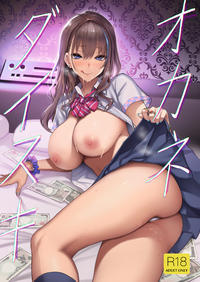

In [123]:
# load iamge from local drive
i = Image.open('okane.jpg')
i

dd53833cc79cbd9d7c9bf1b1bb401284d84942ce-5822542-2508-3541-jpg_l.jpg
okane123.jpg


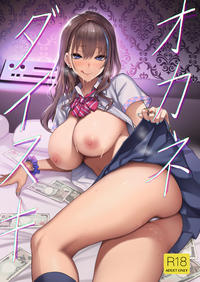

In [135]:
filename = cover_url.split('/')[-1]
print(filename)
ext = filename[filename.find('.')+1 :]
filepath = 'okane123' + '.' + ext
print(filepath)
with open('okane123' + '.' + ext, 'wb') as f:
    f.write(r.content)  
# load iamge from local drive
i2 = Image.open('okane123.jpg')
i2    

In [131]:
'okane.jpg'.find('.')
txt = 'okane.jpg'
txt[6:]

'jpg'

In [146]:
cwd = os.getcwd()
#dtb_fol = 'database'
gid = g1.get_gid()
content = json.loads(g1.resp.content)
#database_path = os.path.join(cwd,dtb_fol)
database_path = 'D:\sadpanda\database'
#print(path)
os.makedirs(path, exist_ok=True)
gid = 142352390
new_folder = str(gid)
new_path = os.path.join(database_path, new_folder)
os.makedirs(new_path, exist_ok=True)
path



'D:\\sadpanda\\database'

In [162]:
content = json.loads(g1.resp.content)
filepath = os.path.join(database_path, 'data.json')
with open(filepath, 'w') as outfile:
    json.dump(content, outfile)

In [165]:
with open(filepath) as json_file:
    raw_data = json.load(json_file)
    print(raw_data)

{'gmetadata': [{'gid': 1824475, 'token': '58cc4ae24a', 'archiver_key': '447490--bf5b43e25c2ffc65d4d2b943038556676a3afc0f', 'title': '[Memeya (Meme50)] Okane Daisuki', 'title_jpn': '[メメ屋 (メメ50)] オカネダイスキ', 'category': 'Doujinshi', 'thumb': 'https://ehgt.org/dd/53/dd53833cc79cbd9d7c9bf1b1bb401284d84942ce-5822542-2508-3541-jpg_l.jpg', 'uploader': 'nrdn25', 'posted': '1610591009', 'filecount': '40', 'filesize': 143026823, 'expunged': False, 'rating': '4.72', 'torrentcount': '2', 'torrents': [{'hash': 'f812e520bb6cd598409689788222576e59928c19', 'added': '1610454452', 'name': '(同人誌) [メメ屋 (メメ50)] オカネダイスキ FANZA版 (オリジナル).zip', 'tsize': '18612', 'fsize': '29881676'}, {'hash': '201c599aa72d65a3fcd2b085d49e40333738e5b8', 'added': '1610517209', 'name': '(同人誌) [メメ屋 (メメ50)] オカネダイスキ FANZA版 (オリジナル).zip', 'tsize': '11354', 'fsize': '287566099'}], 'tags': ['parody:original', 'group:memeya', 'artist:meme50', 'male:bbm', 'male:dilf', 'male:old man', 'female:ahegao', 'female:big breasts', 'female:blowjob', '

In [147]:
r.content

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01^\x01^\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\x1a\x00\xc8\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x03\x06\x01\x02\x07\x00\x08\xff\xc4\x00E\x10\x00\x02\x01\x03\x02\x03\x06\x03\x05\x05\x05\x07\x03\x05\x00\x00\x01\x02\x03\x00\x04\x11\x05!\x121A\x06\x13"Qaq\x14\x81\x912B\xa1\xb1\xc1\x15#Rb\xd1\x073Cr\xf0\x16$s\x82\xc2\xe1\xf14D\x92%S\x93\xa2\xb2\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x00\x04\x05\x06\xff\xc4\x006\x11\x00\x02\x02\x01\x03\x02\x04\x03\x07\x04\x02\x02\x03\x00\x00\x00\x00\x01\x02\x11\x03\x12!1AQ\x04\x13"a2

In [160]:
g1.resp.content_type

AttributeError: 'Response' object has no attribute 'content_type'

In [7]:
d = {'a':1, 'b':2}
d.get(2, 'None')

'None'